In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm
import nltk
import string

tqdm.pandas()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

nltk.download("stopwords")


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielanunez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Loading some packages, then reading in the data. This dataset is an aggregation of 5,169 tweets and their corresponding class, where class 0 indicates No Spam/Not Bot and class 1 indicates Spam/Bot Activity.

In [45]:
import pandas as pd

df = pd.read_csv("/Users/danielanunez/Desktop/CompLing Projects/twitterspamdata.csv", on_bad_lines="skip", low_memory=False)

In [46]:
df.head()

,class,tweets
0,0,Thank u!
1,0,Going for dinner.msg you after.
2,0,Hi i won't b ard 4 christmas. But do enjoy n m...
3,0,1. Tension face 2. Smiling face 3. Waste face ...
4,0,1 I don't have her number and 2 its gonna be a...


Data Preprocessing

Before feeding the corpus through a model, it is necessary to go through the tweets and remove the unnecessary information. Because textual data can be extremely unorganized and unstructured, certain measures must be taken before proceeding with further analysis. The following code transforms all the words in the tweets column to lowercase, as well as removing any punctuation present in the text.

In [49]:
def replace_punctuation(tweet):
   
    tweet = tweet.lower()
    # Replace punctuation marks between two words with a space, excluding apostrophes
    tweet = re.sub(r"(?<=\w)([.,!?;:])(?=(\s|\w))(?=\w)", ' ', tweet)
    # Remove all other punctuation marks
    tweet = re.sub(r'[^\w\s\']', '', tweet)
    return tweet

# Apply the function to the 'tweets' column
df['tweets'] = df['tweets'].apply(replace_punctuation)

df.head()

,class,tweets
0,0,thank u
1,0,going for dinner msg you after
2,0,hi i won't b ard 4 christmas but do enjoy n me...
3,0,1 tension face 2 smiling face 3 waste face 4 i...
4,0,1 i don't have her number and 2 its gonna be a...


It is also necessary to remove stopwords, so that the most vague and commonly used English words do not interfere with model performance and classification. Some examples of stopwords are "and", "the", "is", or "are", none of which carry significant meaning on their own. Removing stopwords allows the model to focus on more meaningful words in a text, thus improving sentiment analysis, text classification, and information retrieval. The NLTK library contains a pre-defined list of stopwords for various languages, making it easy to filter out such words from the model.

In [52]:
from nltk.stem import WordNetLemmatizer

In [53]:
def remove_stopwords(text):
    stopwords1 = stopwords.words("english")

    imp = []

    # Storing the important words
    for word in str(text).split():

        if word not in stopwords1:

            # Let's Lemmatize the word as well
            # before appending to the imp_words list.

            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)

            imp.append(word)

    output = " ".join(imp)

    return output


df["tweets"] = df["tweets"].apply(lambda text: remove_stopwords(text))

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df["tweets"])
vectors.shape

features = vectors

In [68]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(tweets):
    doc = nlp.tokenizer(tweets)
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

In [70]:
train, test = train_test_split(df, test_size=0.1, random_state=619)

In [71]:
train["tokens"] = train["tweets"].progress_apply(tokenize)
test["tokens"] = test["tweets"].progress_apply(tokenize)

  0%|          | 0/5014 [00:00<?, ?it/s]

  0%|          | 0/558 [00:00<?, ?it/s]

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [73]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())
mnb.fit(train["tokens"], train["class"])
print(classification_report(test["class"], mnb.predict(test["tokens"]), digits=4))

              precision    recall  f1-score   support

           0     0.9873    0.9894    0.9884       472
           1     0.9412    0.9302    0.9357        86

    accuracy                         0.9803       558
   macro avg     0.9642    0.9598    0.9620       558
weighted avg     0.9802    0.9803    0.9802       558



In [74]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())
mnb.fit(train["tokens"], train["class"])
print(classification_report(test["class"], mnb.predict(test["tokens"]), digits=4))

              precision    recall  f1-score   support

           0     0.9873    0.9894    0.9884       472
           1     0.9412    0.9302    0.9357        86

    accuracy                         0.9803       558
   macro avg     0.9642    0.9598    0.9620       558
weighted avg     0.9802    0.9803    0.9802       558



In [75]:
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [76]:
search = RandomizedSearchCV(
    mnb,
    {
        "multinomialnb__alpha": loguniform(1e-4, 1.0),
    },
    n_iter=10,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["class"])
search.best_params_

{'multinomialnb__alpha': 0.12448780757096364}

In [77]:
mnb.set_params(**search.best_params_)
mnb.fit(train["tokens"], train["class"])
print(classification_report(test["class"], mnb.predict(test["tokens"])))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       472
           1       0.94      0.94      0.94        86

    accuracy                           0.98       558
   macro avg       0.97      0.97      0.97       558
weighted avg       0.98      0.98      0.98       558



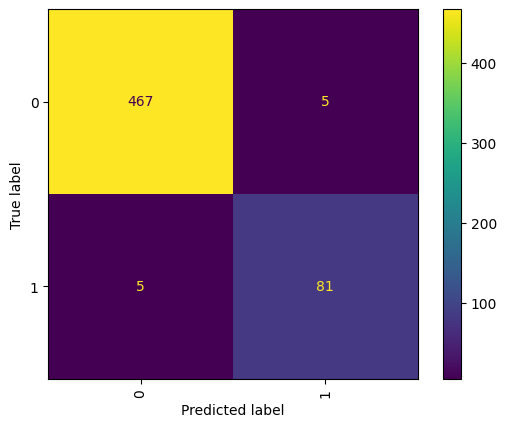

In [78]:
ConfusionMatrixDisplay.from_estimator(
    mnb, test["tokens"], test["class"], xticks_rotation=90
)

Model 1: CountVectorizer + Multinomial Naive Bayes

In [81]:
mnb_save = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=tokenize, token_pattern=None),
    TfidfTransformer(),
    MultinomialNB(),
)
mnb_save.fit(train["tweets"], train["class"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(preprocessor=<cyfunction identity at 0x11447b2a0>,
                                 token_pattern=None,
                                 tokenizer=<function tokenize at 0x1a5796020>)),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

Model 2: SGDClassifier with log loss

In [82]:
sgd = make_pipeline(
    CountVectorizer(analyzer=identity),
    SGDClassifier(
        loss="log_loss", max_iter=2000, tol=0.001, penalty="elasticnet", l1_ratio=0.05
    ),
)
sgd.fit(train["tokens"], train["class"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x11447b2a0>)),
                ('sgdclassifier',
                 SGDClassifier(l1_ratio=0.05, loss='log_loss', max_iter=2000,
                               penalty='elasticnet'))])

In [83]:
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["class"], sgd_predicted))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       0.99      0.91      0.95        86

    accuracy                           0.98       558
   macro avg       0.99      0.95      0.97       558
weighted avg       0.98      0.98      0.98       558



The SGDClassifier model shows high performance, yielding high precision and recall scores. We can further optimize model performance by tuning the hyperparameters.

In [84]:
search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__average": [True, False],
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1_weighted",
)

search.fit(train["tokens"], train["class"])
search.best_score_, search.best_params_

(0.9841006463402362,
 {'sgdclassifier__alpha': 8.246452098327895e-07,
  'sgdclassifier__average': True})

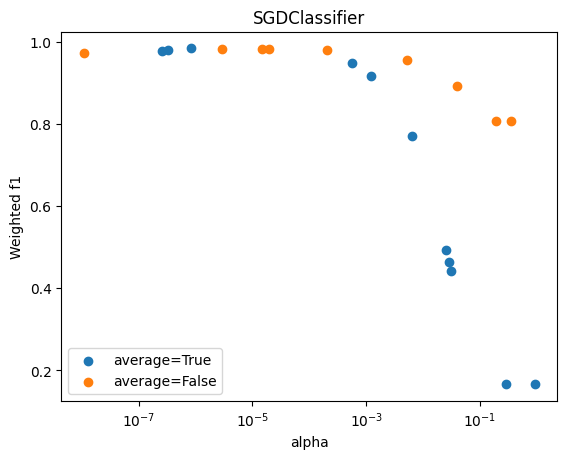

In [85]:
cv_results = pd.DataFrame(search.cv_results_)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==True")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==True")["mean_test_score"],
    label="average=True",
)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==False")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==False")["mean_test_score"],
    label="average=False",
)
plt.semilogx()
plt.title("SGDClassifier")
plt.xlabel("alpha")
plt.ylabel("Weighted f1")
plt.legend()
plt.show()

In [90]:
sgd.set_params(**search.best_params_)
sgd.fit(train["tokens"], train["class"])
print(classification_report(test["class"], sgd.predict(test["tokens"])))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       472
           1       0.99      0.94      0.96        86

    accuracy                           0.99       558
   macro avg       0.99      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



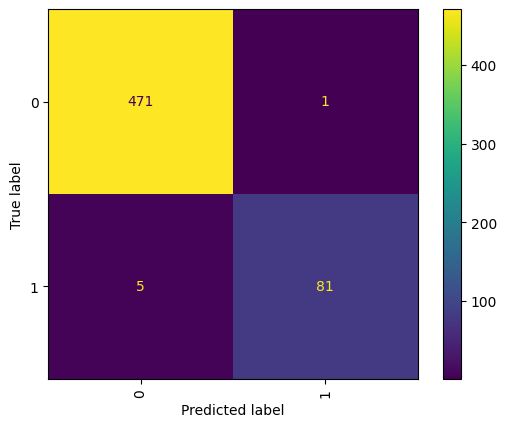

In [91]:
ConfusionMatrixDisplay.from_estimator(
    sgd, test["tokens"], test["class"], xticks_rotation=90
)

The model performs slightly worse when it comes to classifying spam tweets: 5 spam tweets were misclassified as non-bots.

In [94]:
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer

In [95]:
predicted = sgd.predict(test["tweets"])

In [96]:
def boundary(X):
    t = sgd.decision_function(X)
    return np.vstack([t, -t]).T

In [103]:
test["class"].iloc[59], predicted[59]

(1, 0)

[]

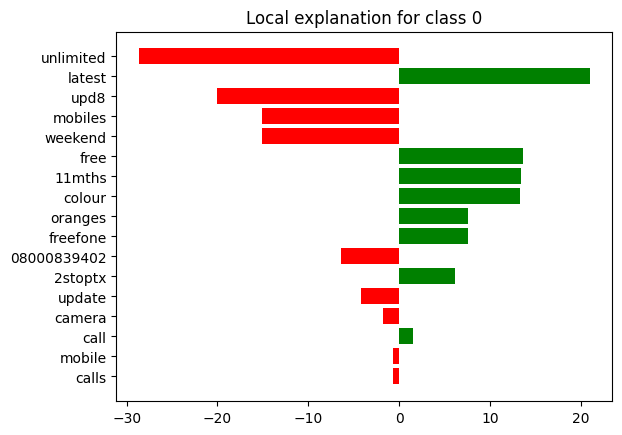

In [100]:
explainer = LimeTextExplainer()

exp = explainer.explain_instance(
    test["tweets"].iloc[59], boundary, num_features=25, num_samples=8, labels=(0,)
)

exp.as_pyplot_figure(0)
plt.plot()

Taking a closer look at what might make this model a bit lacking, it is clear that several specific words may cause misclassification. In tweet 59, which was misclassified as a non-bot (the issue described above), we can see that the model is particularly reactive to words that may have spam undertones, but do not explicitly denote spam (i.e. "mobiles", "unlimited", "weekend"). However, unsurprisingly, "free" and "latest" seem to greatly assist the model in somewhat correctly classifying spam tweets. These words were also present in the word cloud for spam tweets.

In [104]:
labels = sgd.named_steps["sgdclassifier"].classes_
scores = sgd.decision_function(test["tweets"])

predicted = sgd.predict(test["tweets"])

In [105]:
coef = sgd.named_steps["sgdclassifier"].coef_

In [106]:
vocab = sgd.named_steps["countvectorizer"].get_feature_names_out()

In [107]:
ranked = np.argsort(coef, axis=1)
for i in range(-1, -26, -1):
    print(f"{vocab[ranked[0,i]]:15s} {coef[0,ranked[0,i]]:6.3f}")
print()
for i in range(25):
    print(f"{vocab[ranked[0,i]]:15s} {coef[0,ranked[0,i]]:6.3f}")

claim           104.780
txt             89.159
co              72.834
opt             72.475
voucher         69.482
std             68.218
prize           67.862
bid             67.540
service         64.823
chat            62.837
150pmsg         60.026
ringtone        58.362
www             58.120
content         57.646
freemsg         57.297
charity         56.735
sexy            56.056
tone            55.795
uk              55.521
sky             54.661
mob             54.567
tones           53.037
dating          52.552
video           52.367
access          51.567

ltgt            -105.611
x               -73.460
later           -64.375
amp             -63.734
world           -59.491
bed             -54.222
mine            -54.208
hair            -54.102
without         -53.227
tick            -53.214
fullonsms       -52.762
k               -51.850
hi              -51.226
well            -48.704
always          -44.647
morning         -42.430
weekend         -42.337
that          

The first loop outputs the top 25 words with the highest coefficients, meaning that they have the highest level of contribution to accurately classifying a tweet as spam.

The second loop outputs the top 25 words that have the highest level of contribution to accurately classifying a tweet as non-spam.

